# Attrition Prediction

Name: Aryamaan Saha  
Rollno: BE19B014  
College: Indian Institute of Technology, Madras

### Importing necessary libraries

In [259]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

## Data preprocessing and visualization

In [2]:
df = pd.read_csv('HR_comma_sep.csv')
df

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,support,low
14995,0.37,0.48,2,160,3,0,1,0,support,low
14996,0.37,0.53,2,143,3,0,1,0,support,low
14997,0.11,0.96,6,280,4,0,1,0,support,low


In [3]:
categorical_features = ['Work_accident', 'left', 'promotion_last_5years', 'Department','salary']
df[categorical_features] = df[categorical_features].astype(object)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  object 
 6   left                   14999 non-null  object 
 7   promotion_last_5years  14999 non-null  object 
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(3), object(5)
memory usage: 1.1+ MB


In [260]:
df.isnull().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
Department               0
salary                   0
dtype: int64

There are no missing values

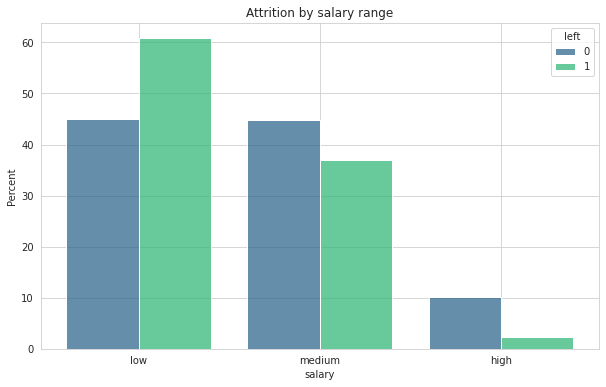

In [207]:
plt.figure(figsize=(10,6))
sns.histplot(x = df['salary'], hue=df['left'], multiple="dodge", 
                stat = 'percent', shrink=0.8, common_norm=False, palette='viridis')
plt.title('Attrition by salary range')
plt.show()

The trends are as expected, for low salary there are more people that have left than those that have stayed. For high salary range, most of the folks have stayed. 

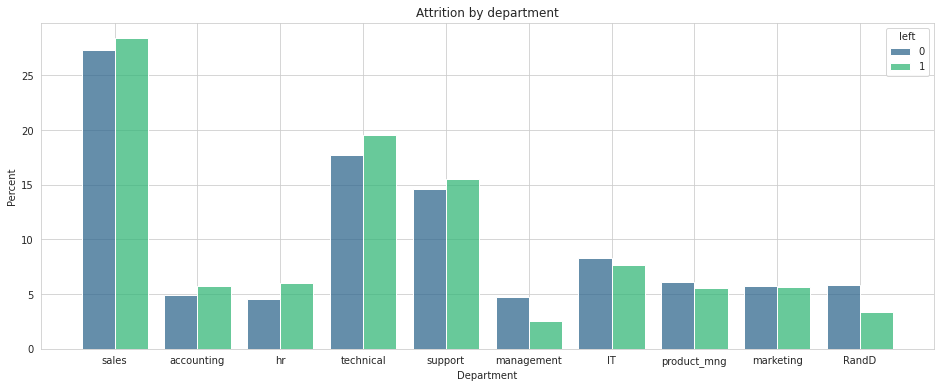

In [206]:
plt.figure(figsize=(16,6))
sns.histplot(x = df['Department'], hue=df['left'], multiple="dodge", 
                stat = 'percent', shrink=0.8, common_norm=False, palette='viridis')
plt.title('Attrition by department')
plt.show()

There's not much of a difference between departments

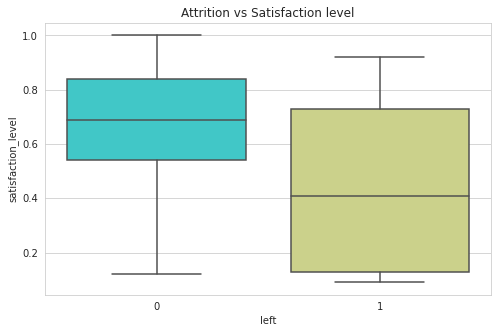

In [205]:
plt.figure(figsize=(8,5))
sns.boxplot(x='left',y='satisfaction_level',data=df, palette='rainbow')
plt.title('Attrition vs Satisfaction level')
plt.show()

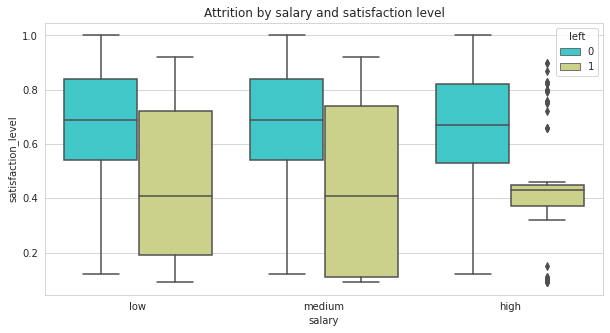

In [208]:
plt.figure(figsize=(10,5))
sns.boxplot(x='salary',y='satisfaction_level', hue='left',data=df, palette='rainbow')
plt.title("Attrition by salary and satisfaction level")
plt.show()

In [214]:
df['left'].value_counts(normalize=True)

0    0.761917
1    0.238083
Name: left, dtype: float64

As expected, there's a fairly large class imbalance in our data, the people who stay occupy most of the data points in the dataset (76%). To fix this class imbalance, we'll use an oversampling method for the minority class called SMOTE later on while building the model.

We analyze the correlations between numerical features. While building the model, we wouldn't want to feed in correlated features as that would be counterproductive (multicollinearity)

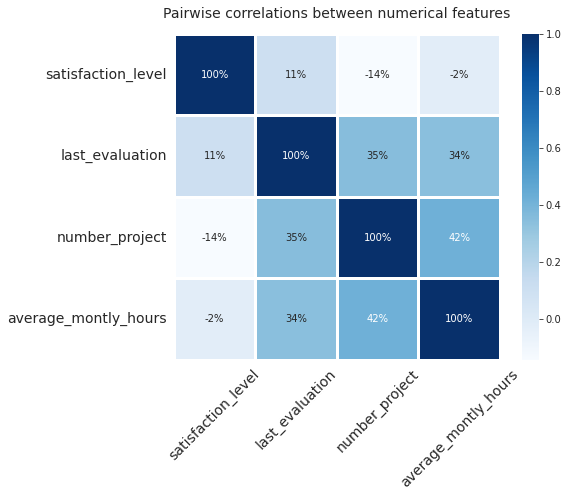

In [209]:
fig=plt.figure(figsize=(8,6))
numerical_features = list(df.select_dtypes(['int', 'float']).columns[:-1])
ax=sns.heatmap(df[numerical_features].corr(), annot=True, linewidths=3, square=True, cmap='Blues', fmt=".0%")

ax.set_title('Pairwise correlations between numerical features', fontsize=14, x=0.50, y=1.03);
ax.set_xticklabels(numerical_features, fontsize=14, rotation = 45)
ax.set_yticklabels(numerical_features, fontsize=14, rotation= 0);

There doesn't seem to be much of a correlation between features, so we can proceed with our model  
## Modeling  
We one-hot encode the categorical features and use a 75-25 split for training

In [211]:
X = df.copy()
y = X.pop('left')
X = pd.get_dummies(X, drop_first=True)

In [212]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
y_train.value_counts(normalize=True)

0    0.765401
1    0.234599
Name: left, dtype: float64

Having a major class imbalance in problematic in data analysis. In this case, if we predicted that a new employee would never leave, then we'd be 76% accurate everytime.   
To fix the class imbalance in the training set, we use an oversampling technique called SMOTE. Here I've also slightly undersampled the majority class to bring the proportions closer together.

In [226]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline
smote_pipeline = make_pipeline(SMOTE(sampling_strategy=.6), 
                                 RandomUnderSampler(sampling_strategy=.7))
X_train_smote, y_train_smote = smote_pipeline.fit_resample(X_train,y_train.astype(np.int32))
y_train_smote.value_counts(normalize=True), y_train_smote.value_counts()

(0    0.588235
 1    0.411765
 Name: left, dtype: float64,
 0    7380
 1    5166
 Name: left, dtype: int64)

58-41 split for the class proportions is good enough for us to proceed with building the model

# Decision Tree Classifier

In [257]:
from sklearn.tree import DecisionTreeClassifier
params ={
    'criterion' : 'gini',
    'min_samples_split': 25,
}
dtc = DecisionTreeClassifier(**params)
dtc.fit(X_train_smote, y_train_smote)

### Performace on test set

In [258]:
from sklearn.metrics import classification_report, accuracy_score
y_pred = dtc.predict(X_test)
print(classification_report(y_test.astype('int32'), y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2818
           1       0.94      0.94      0.94       932

    accuracy                           0.97      3750
   macro avg       0.96      0.96      0.96      3750
weighted avg       0.97      0.97      0.97      3750



# Gradient Boost Classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
params ={
    'learning_rate' : 0.1,
    'n_estimators': 1000,
    'subsample': 1.0,
    'min_samples_leaf': 10,
    'max_depth': 5,
    'max_features' : 'sqrt',
    'verbose': 1
}
gbc = GradientBoostingClassifier(**params)
gbc.fit(X_train_smote, y_train_smote)

### Performace on test set

In [255]:
from sklearn.metrics import classification_report, accuracy_score
y_pred = gbc.predict(X_test)
print(classification_report(y_test.astype('int32'), y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2818
           1       0.97      0.98      0.97       932

    accuracy                           0.99      3750
   macro avg       0.98      0.98      0.98      3750
weighted avg       0.99      0.99      0.99      3750



We're mainly concerned with the recall or the true positive rate(TPR) here, as we'd like to predict every employee that wants to leave and not have any room for false negatives. As mentioned earlier, metrics like accuracy isn't very useful when the data set has an imbalance.    
TPR(Decision Tree) = 94%  
TPR(Gradient Boost) = 98%  
The performances on the test set for Gradient Boost is better, albeit marginally. There's no real need to try out any more models and improve it further, and the marginal gain in recall is likely not worth the additional computational cost. 

In [269]:
import pickle
fname = 'gradientboostmodel.sav'
pickle.dump(gbc, open(fname, 'wb'))

### Feature Importance   
We use the Gradient Boosted classifier to compute the feature importances. It looks like satisfaction level, number of projects, time spent at company and avg monthly hours have the most importance (> 17%) in the model

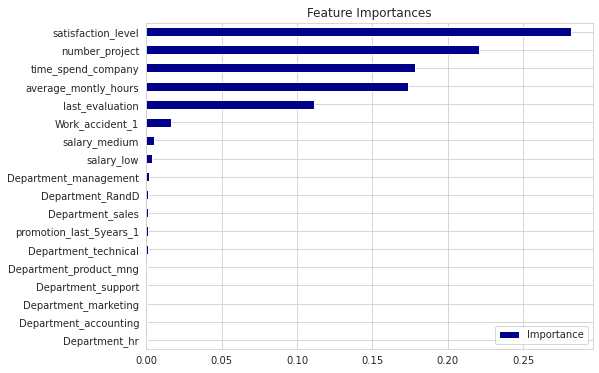

In [253]:
fi = pd.DataFrame(gbc.feature_importances_,index=X_train_smote.columns,columns=['Importance']).sort_values('Importance',ascending=True)
fi.plot.barh(color='darkblue')
plt.gcf().set_size_inches((8, 6))
plt.title("Feature Importances")
plt.legend(loc='lower right')
plt.show()

### Load and use the trained GB model directly

In [268]:
m = pickle.load(open(fname, 'rb'))
# m.predict